In [1]:
ALL_SEEDS = [11696672, 15713537, 36569120, 70206358, 75504233, 83494940, 90478944, 92519636, 95284986, 96488735]
ALL_RATIOS = [1, 2, 4, 8, 16, 32, 64]
SAVE_DIR = 'data/models'
MULTIPLY_ADDS_FILE = 'data/multiply_adds/multiply_adds.json'
BROWSER_PERFORMANCE_FILE = 'data/browser-performance/browser-performance.json'

In [2]:
import torch
from imports.utils import get_filename, ParameterType, get_progress_and_state_dict, PruningType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import json

In [3]:
# This is needed because some of the models where pickled when the import was just "utils"
# Now it is "imports.utils"
from imports import utils
import sys
sys.modules['utils'] = utils

In [4]:
def savefig(name, facecolor=None):
    pass
    #plt.savefig("../../../500 latex/src/plots/" + name, bbox_inches='tight', pad_inches=0.1, facecolor=facecolor)
    
if not os.path.exists('plot_style.txt'):
    with open('plot_style.txt', 'w+') as f:
        f.write("""
figure.figsize: 7.2,4.45
xtick.color: 323034
ytick.color: 323034
text.color: 323034
lines.markeredgecolor: black
patch.facecolor        : black
patch.force_edgecolor  : True
patch.linewidth: 0.8
scatter.edgecolors: black
grid.color: b1afb5
axes.prop_cycle : (cycler('color', ['000000']))
axes.titlesize: 16
legend.title_fontsize: 12
xtick.labelsize: 12
ytick.labelsize: 12
axes.labelsize: 12
font.size: 10
mathtext.fontset: stix
font.family: STIXGeneral
lines.linewidth: 2
legend.frameon: True
legend.framealpha: 0.8
legend.fontsize: 10
legend.edgecolor: 0.9
legend.borderpad: 0.2
legend.columnspacing: 1.5
legend.labelspacing:  0.4
text.usetex: False
axes.titlelocation: left
axes.formatter.use_mathtext: True
axes.autolimit_mode: round_numbers
axes.labelpad: 3
axes.formatter.limits: -4, 4
axes.labelcolor: black
axes.edgecolor: black
axes.linewidth: 0.6
axes.spines.right : False
axes.spines.top : False
axes.grid: False
figure.titlesize: 18
figure.dpi: 300
        """)
plt.style.use('plot_style.txt')

In [5]:
BLUE="#3835FD"
DARKBLUE="#04018D"
BLACK="#000000"

# Utilities

In [6]:
def convert_to_top1(ls):
    if len(ls) == 0:
        return ls
    
    if type(ls[0]) == list:
        return [x[0] for x in ls]
        
    return ls

def percent_to_cr(percent):
    return [100 / x for x in percent]

def error_to_acc(err):
    return [1 - x/100 for x in err]

def remove_initial(df):
    if not hasattr(df, 'compression_ratio'): return df

    return df[df.compression_ratio != 1]

In [7]:
with open(MULTIPLY_ADDS_FILE, "r") as f:
    multiply_adds = pd.DataFrame(json.load(f))
    
multiply_adds.head()

,seed,compression_ratio,multiply_adds
0,11696672,1,126276224
1,11696672,2,61951007
2,11696672,4,33251852
3,11696672,8,18641858
4,11696672,16,10623984


In [8]:
def add_best_accuracy(data_df):
    best_accuracies = []

    for i in range(len(data_df)):
        best_accuracies.append(max(data_df.iloc[i].all_accuracies))

    data_df["best_accuracy"] = best_accuracies
    
def add_accuracy_changes(data_df):
    accuracy_changes = []

    for i in range(len(data_df)):
        this_row = data_df.iloc[i]

        base_row = data_df[(data_df.seed == this_row.seed) & (data_df.compression_ratio == 1.0)]

        assert len(base_row) == 1
        base_acc = base_row.iloc[0].best_accuracy

        accuracy_changes.append(100 * (this_row.best_accuracy - base_acc)/base_acc)

    data_df["accuracy_change"] = accuracy_changes
    
def add_speedups(data_df, input_col='multiply_adds', output_col='speedup'):
    speedups = []

    for i in range(len(data_df)):
        this_row = data_df.iloc[i]

        base_row = data_df[(data_df.seed == this_row.seed) & (data_df.compression_ratio == 1.0)]

        assert len(base_row) == 1
        base_ma = base_row.iloc[0][input_col]

        speedups.append(base_ma/this_row[input_col])

    data_df[output_col] = speedups

# Main

In [10]:
data_final = []

for pruning_type in [PruningType.LT_TRADITIONAL]:
    for seed in ALL_SEEDS:
        for ratio in ALL_RATIOS:
            for parameter_type in [ParameterType.FINAL]:
                filename = get_filename(SAVE_DIR, seed, ratio, parameter_type, pruning_type, 0 if ratio == 1 else 1)

                progress = get_progress_and_state_dict(filename, _cpu_only=True)
                del progress['state_dict']
                del progress['next_epoch']
                progress['all_accuracies'] = convert_to_top1(progress['all_accuracies'])
                progress['type'] = progress['type'].value
                progress['pruning_type'] = pruning_type.value
                progress['name'] = 'Ours'
                
                ma = multiply_adds[(multiply_adds.seed == seed) & (multiply_adds.compression_ratio == ratio)]
                assert len(ma) == 1
                progress['multiply_adds'] = ma.multiply_adds.iloc[0]

                data_final.append(progress)
            
data_final = pd.DataFrame(data_final)
data_final = data_final.drop(columns=['type', 'pruning_type', 'iterative_round'])

assert len(data_final) == len(ALL_RATIOS) * len(ALL_SEEDS)

data_final.head()

,compression_ratio,all_accuracies,seed,name,multiply_adds
0,1.0,"[36.03, 43.85, 52.78, 62.25, 67.73, 69.24, 73....",11696672,Ours,126276224
1,2.0,"[40.31, 55.03, 59.63, 60.11, 71.81, 72.01, 77....",11696672,Ours,61951007
2,4.0,"[45.26, 58.29, 68.64, 57.49, 76.77, 72.97, 76....",11696672,Ours,33251852
3,8.0,"[36.650001525878906, 53.220001220703125, 60.40...",11696672,Ours,18641858
4,16.0,"[39.689998626708984, 52.33000183105469, 58.849...",11696672,Ours,10623984


In [12]:
add_best_accuracy(data_final)

data_final.head()

,compression_ratio,all_accuracies,seed,name,multiply_adds,best_accuracy
0,1.0,"[36.03, 43.85, 52.78, 62.25, 67.73, 69.24, 73....",11696672,Ours,126276224,93.420000
1,2.0,"[40.31, 55.03, 59.63, 60.11, 71.81, 72.01, 77....",11696672,Ours,61951007,92.710000
2,4.0,"[45.26, 58.29, 68.64, 57.49, 76.77, 72.97, 76....",11696672,Ours,33251852,92.290000
3,8.0,"[36.650001525878906, 53.220001220703125, 60.40...",11696672,Ours,18641858,90.879997
4,16.0,"[39.689998626708984, 52.33000183105469, 58.849...",11696672,Ours,10623984,89.110001


# Accuracies

In [13]:
for r in ALL_RATIOS:
    print("Compression ratio:", r)
    dd = data_final[data_final.compression_ratio == r].best_accuracy
    print("{:0.2f} +- {:0.2f}".format(dd.mean(), dd.std()))

Compression ratio: 1
92.74 +- 0.64
Compression ratio: 2
92.29 +- 0.55
Compression ratio: 4
91.38 +- 0.53
Compression ratio: 8
90.14 +- 0.60
Compression ratio: 16
88.78 +- 0.46
Compression ratio: 32
85.72 +- 0.48
Compression ratio: 64
79.86 +- 0.62


In [14]:
diffs = []

for seed in ALL_SEEDS:
    dd = data_final[data_final.seed == seed]
    diffs.append(dd[dd.compression_ratio == 1].iloc[0].best_accuracy - dd[dd.compression_ratio == 2].iloc[0].best_accuracy)
    
pd.DataFrame(diffs).describe()

,0
count,10.000000
mean,0.451000
std,0.489024
min,-0.129997
25%,0.094997
50%,0.365002
75%,0.679999
max,1.340004


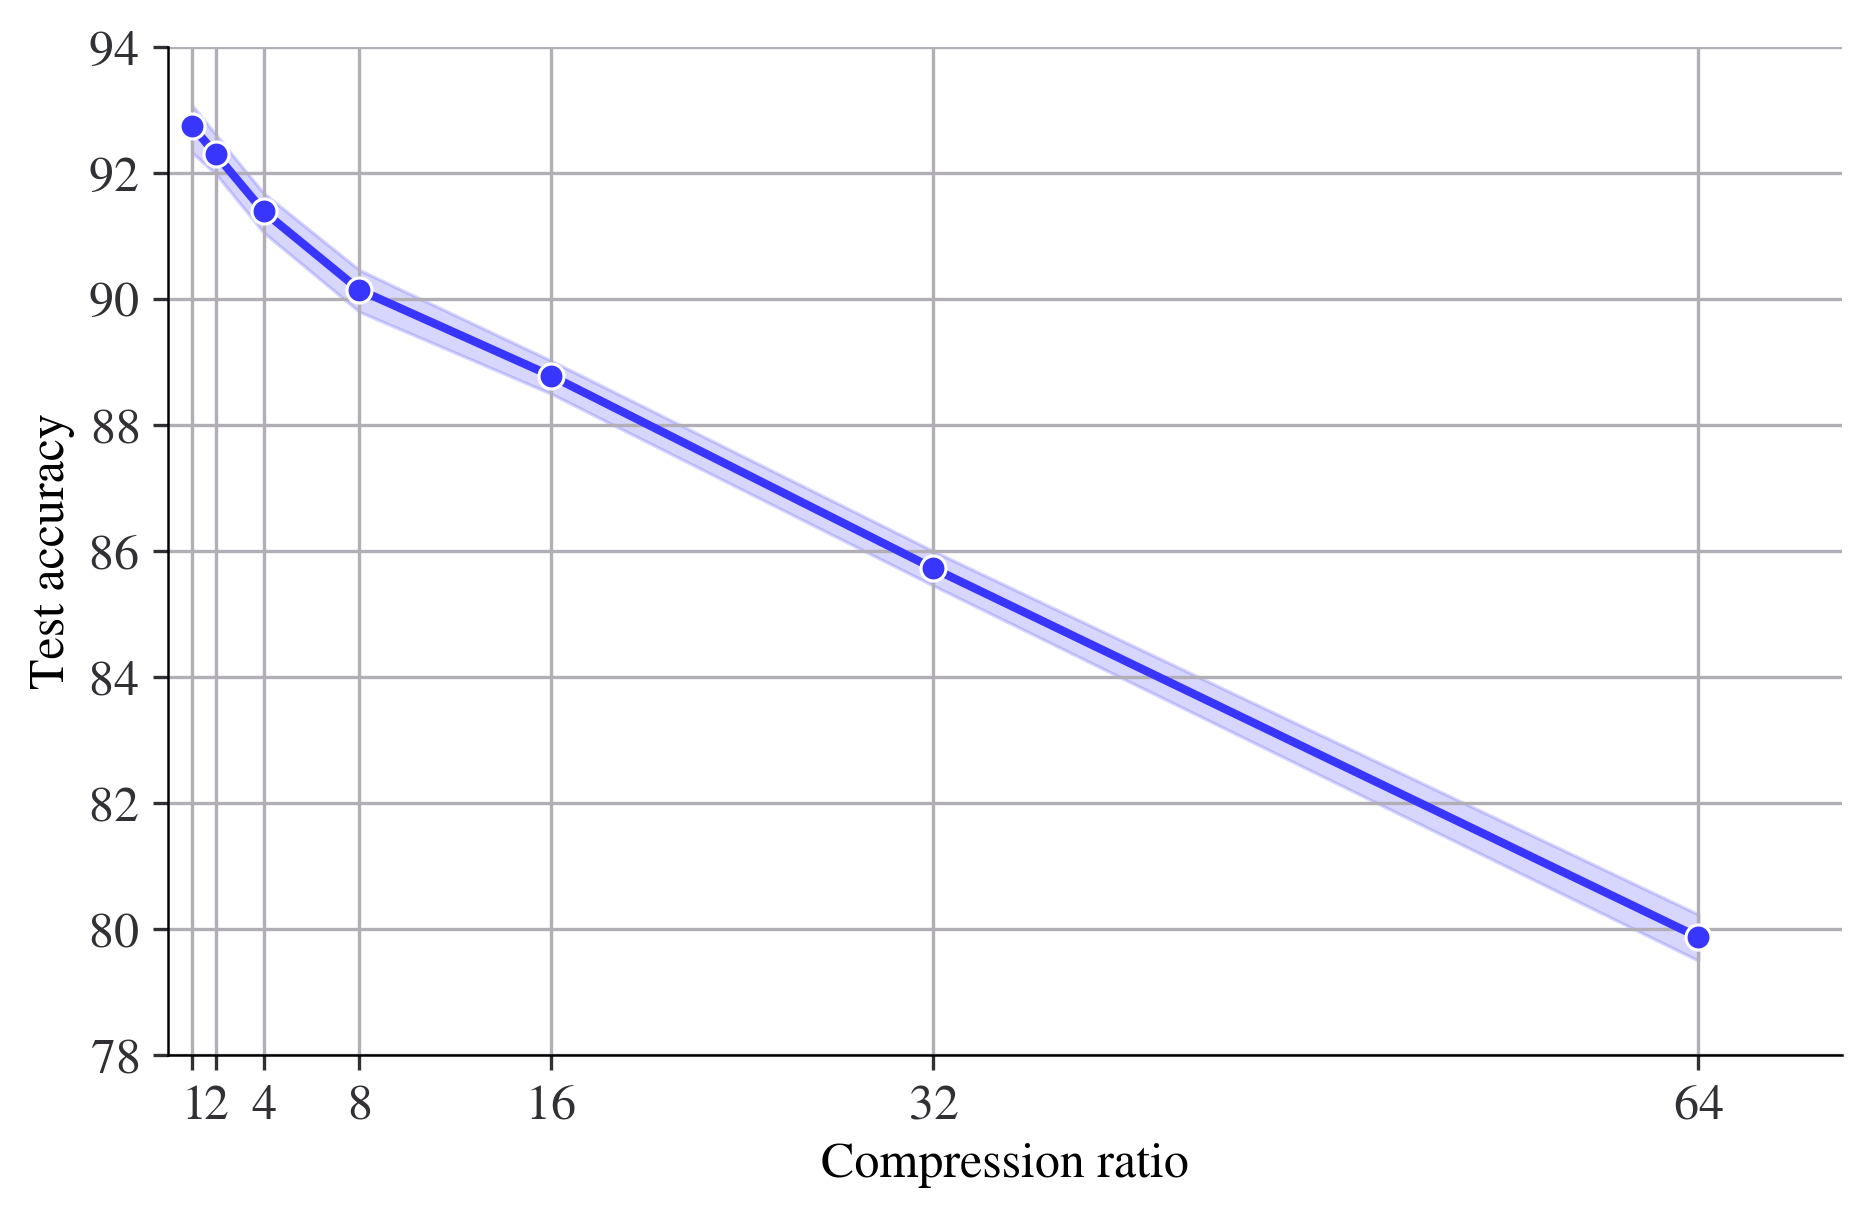

In [15]:
plt.grid()

ax = sns.lineplot(data=data_final, x='compression_ratio', y='best_accuracy', marker="o", color=BLUE)
#ax.set_xscale('log', basex=2)
ax.set_xticks(ALL_RATIOS)
ax.set_xlim(0)
ax.set_xlabel('Compression ratio')
ax.set_ylabel('Test accuracy')

savefig('compression-accuracy.pdf')

In [16]:
add_accuracy_changes(data_final)

data_final.head()

,compression_ratio,all_accuracies,seed,name,multiply_adds,best_accuracy,accuracy_change
0,1.0,"[36.03, 43.85, 52.78, 62.25, 67.73, 69.24, 73....",11696672,Ours,126276224,93.420000,0.000000
1,2.0,"[40.31, 55.03, 59.63, 60.11, 71.81, 72.01, 77....",11696672,Ours,61951007,92.710000,-0.760009
2,4.0,"[45.26, 58.29, 68.64, 57.49, 76.77, 72.97, 76....",11696672,Ours,33251852,92.290000,-1.209591
3,8.0,"[36.650001525878906, 53.220001220703125, 60.40...",11696672,Ours,18641858,90.879997,-2.718907
4,16.0,"[39.689998626708984, 52.33000183105469, 58.849...",11696672,Ours,10623984,89.110001,-4.613572


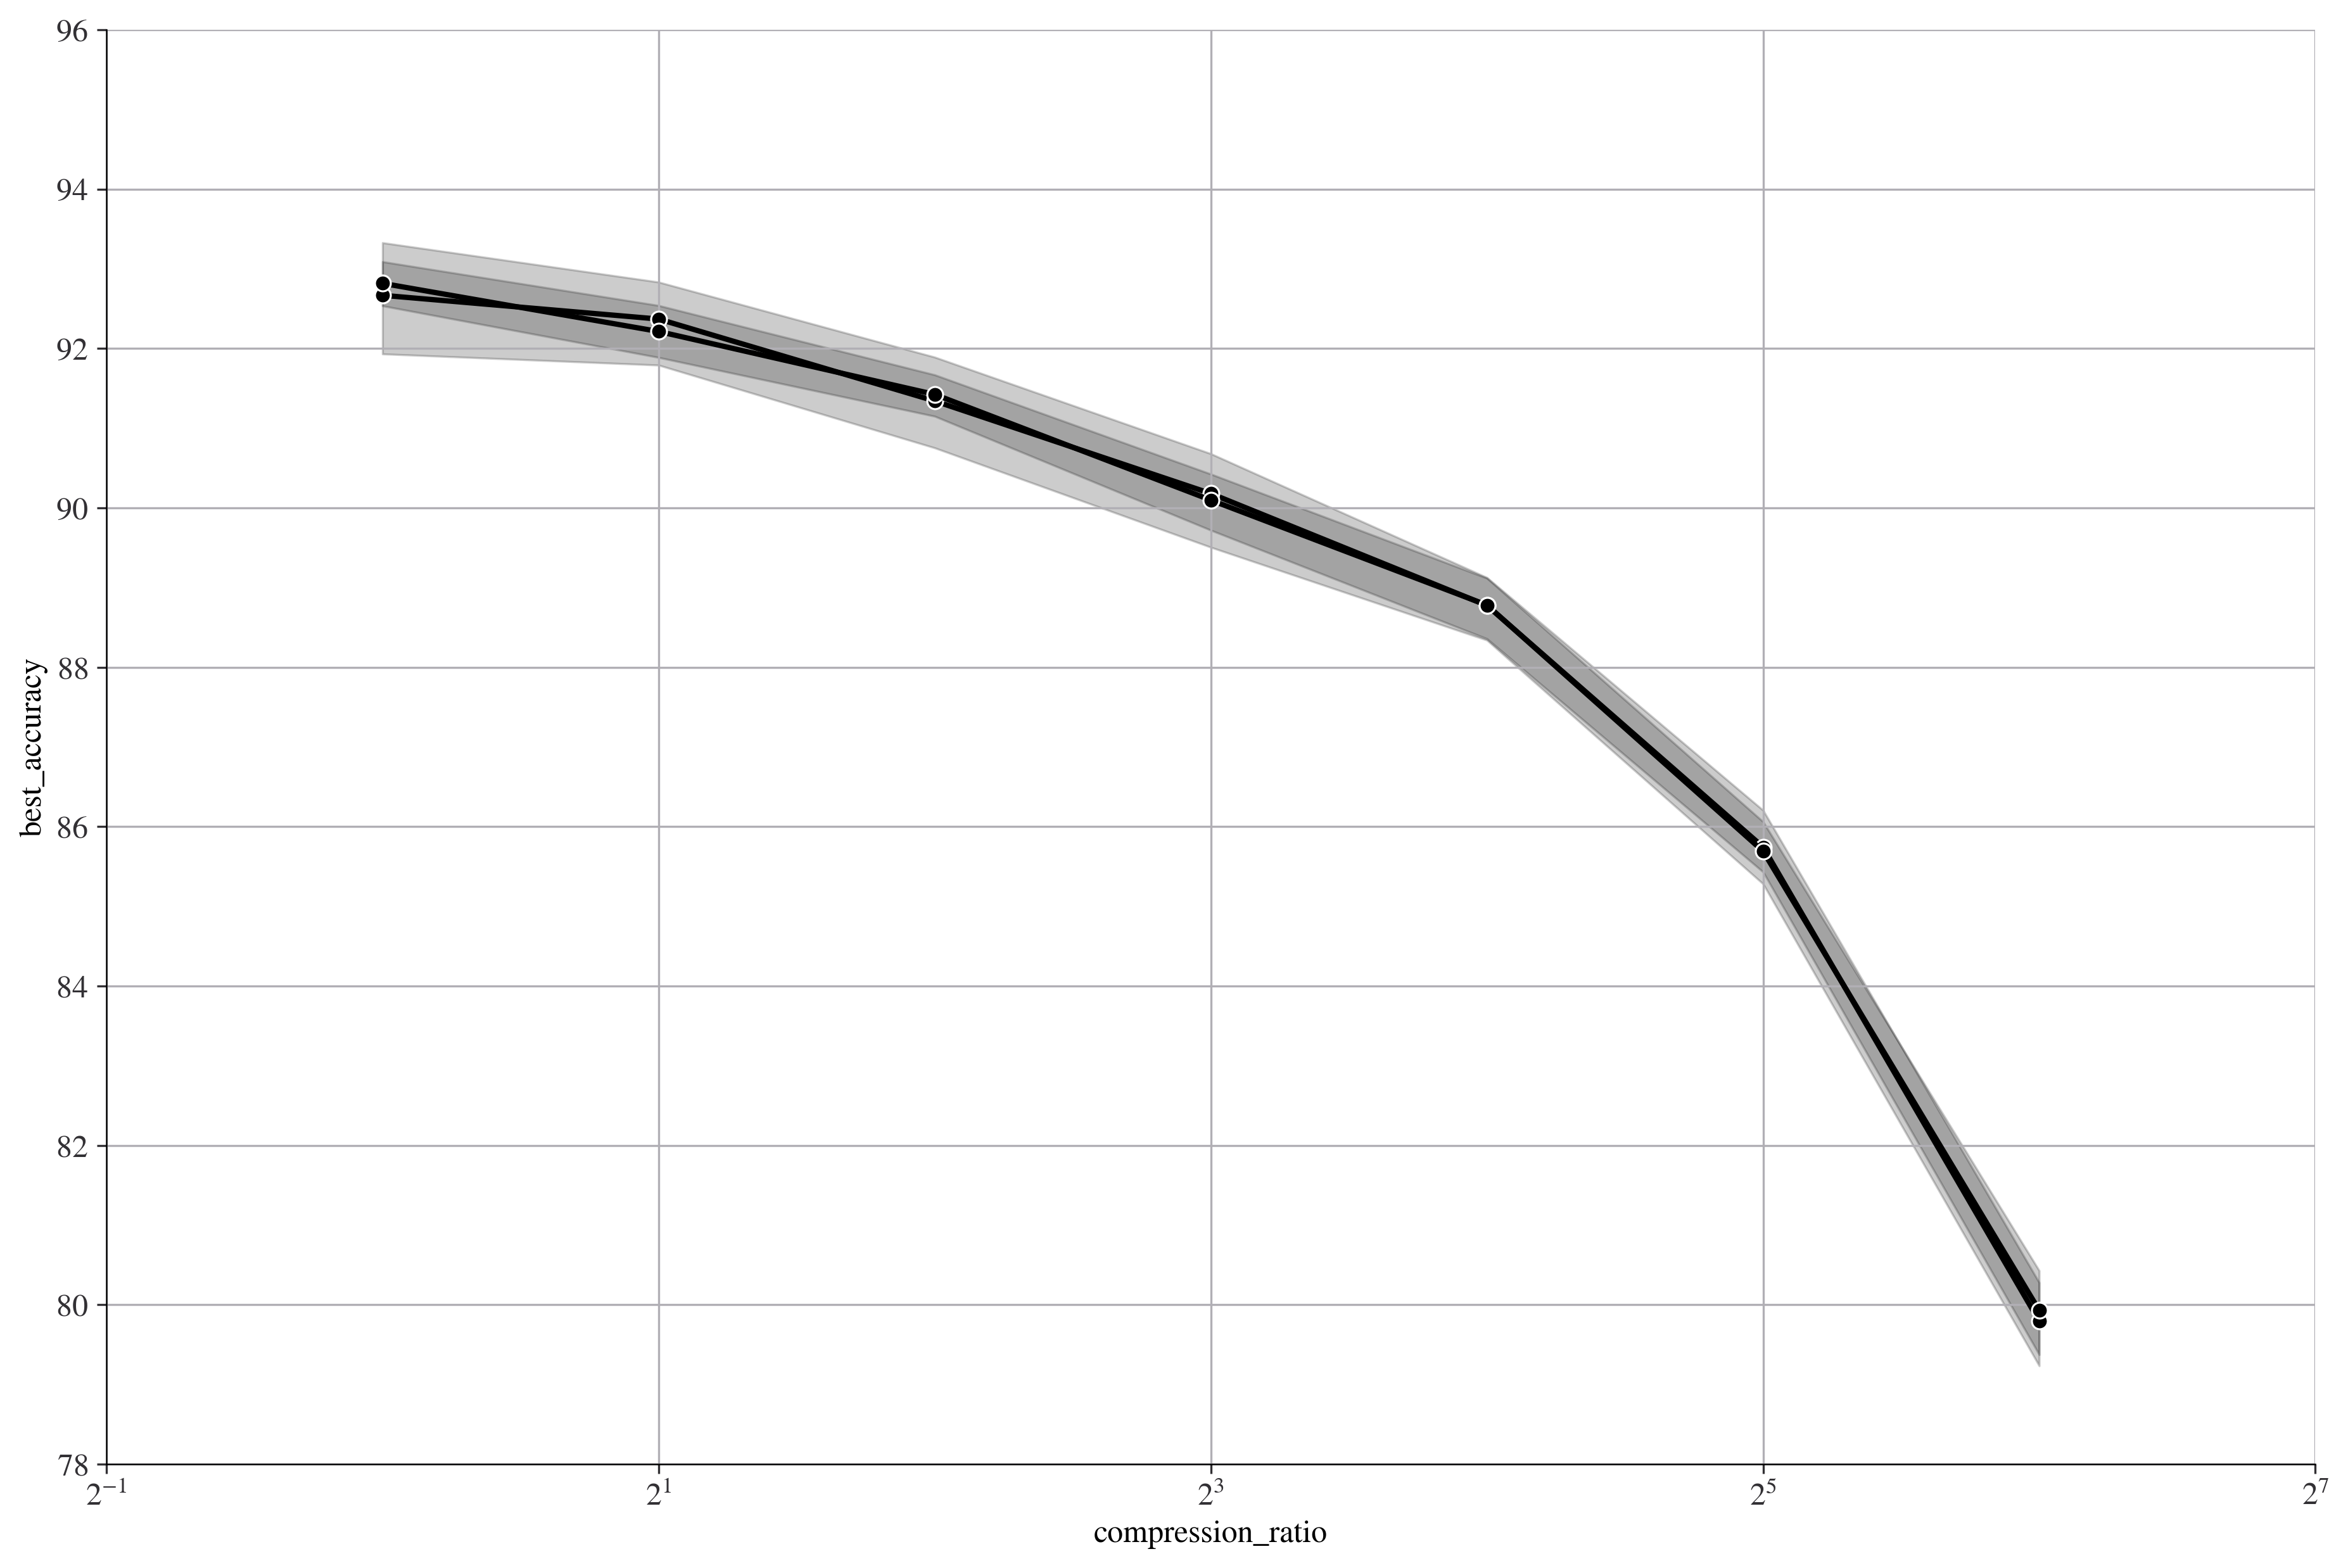

In [19]:
plt.figure(figsize=(15, 10))
plt.grid()

data_first = data_final[data_final.seed.isin(ALL_SEEDS[:5])]
data_last = data_final[data_final.seed.isin(ALL_SEEDS[5:])]

ax = sns.lineplot(data=data_first, x='compression_ratio', y='best_accuracy', marker="o")
sns.lineplot(data=data_last, x='compression_ratio', y='best_accuracy', marker="o", ax=ax)
ax.set_xscale('log', base=2)

# Speedup

In [20]:
add_speedups(data_final)

data_final.head()

,compression_ratio,all_accuracies,seed,name,multiply_adds,best_accuracy,accuracy_change,speedup
0,1.0,"[36.03, 43.85, 52.78, 62.25, 67.73, 69.24, 73....",11696672,Ours,126276224,93.420000,0.000000,1.000000
1,2.0,"[40.31, 55.03, 59.63, 60.11, 71.81, 72.01, 77....",11696672,Ours,61951007,92.710000,-0.760009,2.038324
2,4.0,"[45.26, 58.29, 68.64, 57.49, 76.77, 72.97, 76....",11696672,Ours,33251852,92.290000,-1.209591,3.797570
3,8.0,"[36.650001525878906, 53.220001220703125, 60.40...",11696672,Ours,18641858,90.879997,-2.718907,6.773800
4,16.0,"[39.689998626708984, 52.33000183105469, 58.849...",11696672,Ours,10623984,89.110001,-4.613572,11.885958


In [21]:
for r in ALL_RATIOS:
    print("Compression ratio:", r)
    dd = data_final[data_final.compression_ratio == r].speedup
    print("{:0.2f} +- {:0.2f}".format(dd.mean(), dd.std()))

Compression ratio: 1
1.00 +- 0.00
Compression ratio: 2
2.19 +- 0.30
Compression ratio: 4
4.18 +- 0.77
Compression ratio: 8
7.62 +- 1.59
Compression ratio: 16
13.55 +- 3.04
Compression ratio: 32
24.05 +- 5.48
Compression ratio: 64
45.09 +- 9.71


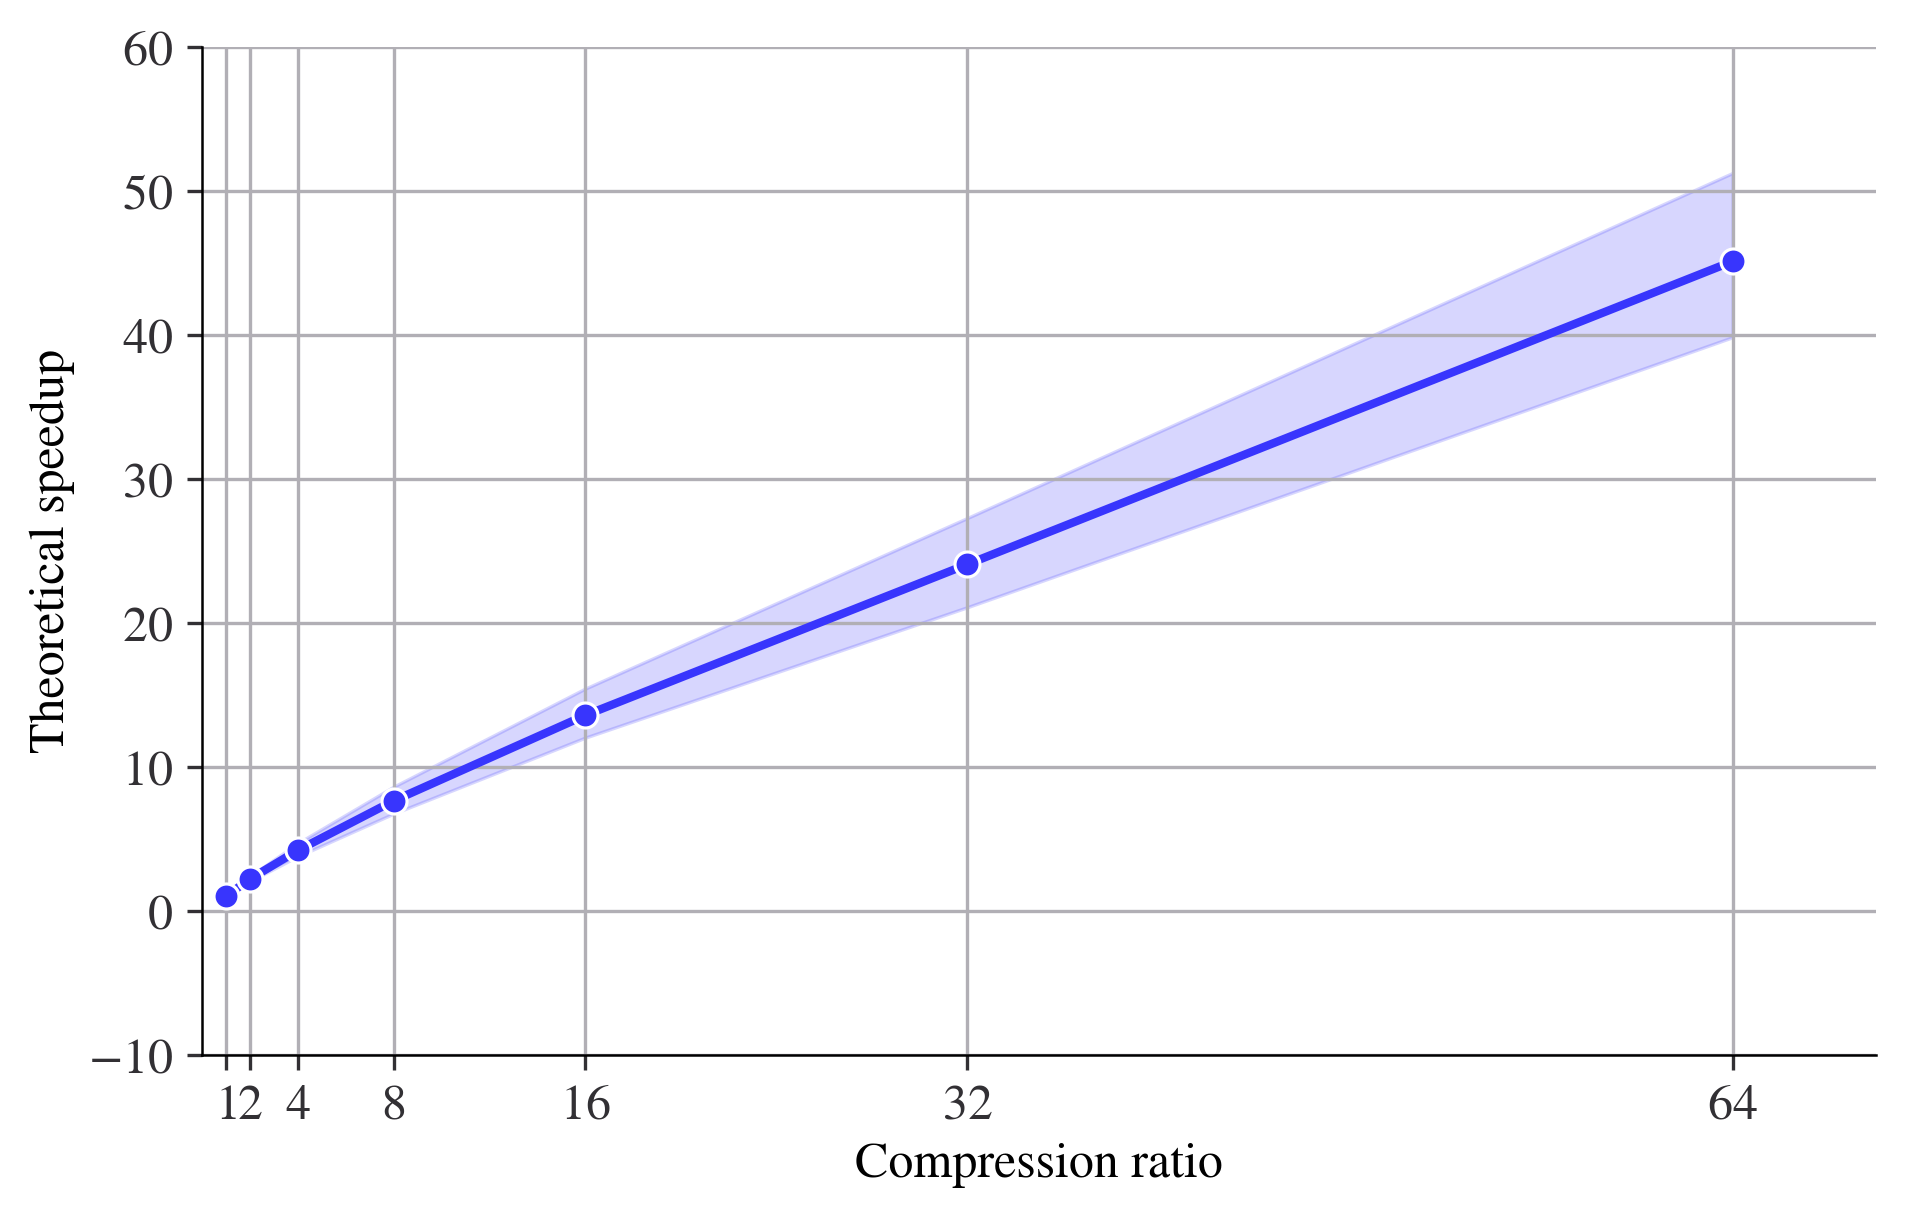

In [22]:
plt.grid()

ax = sns.lineplot(data=data_final, x='compression_ratio', y='speedup', marker="o", color=BLUE)
#ax.set_yscale('log', basey=10)
ax.set_xticks(ALL_RATIOS)
ax.set_xlim(0)
ax.set_xlabel('Compression ratio')
ax.set_ylabel('Theoretical speedup')

savefig('compression-speedup.pdf')

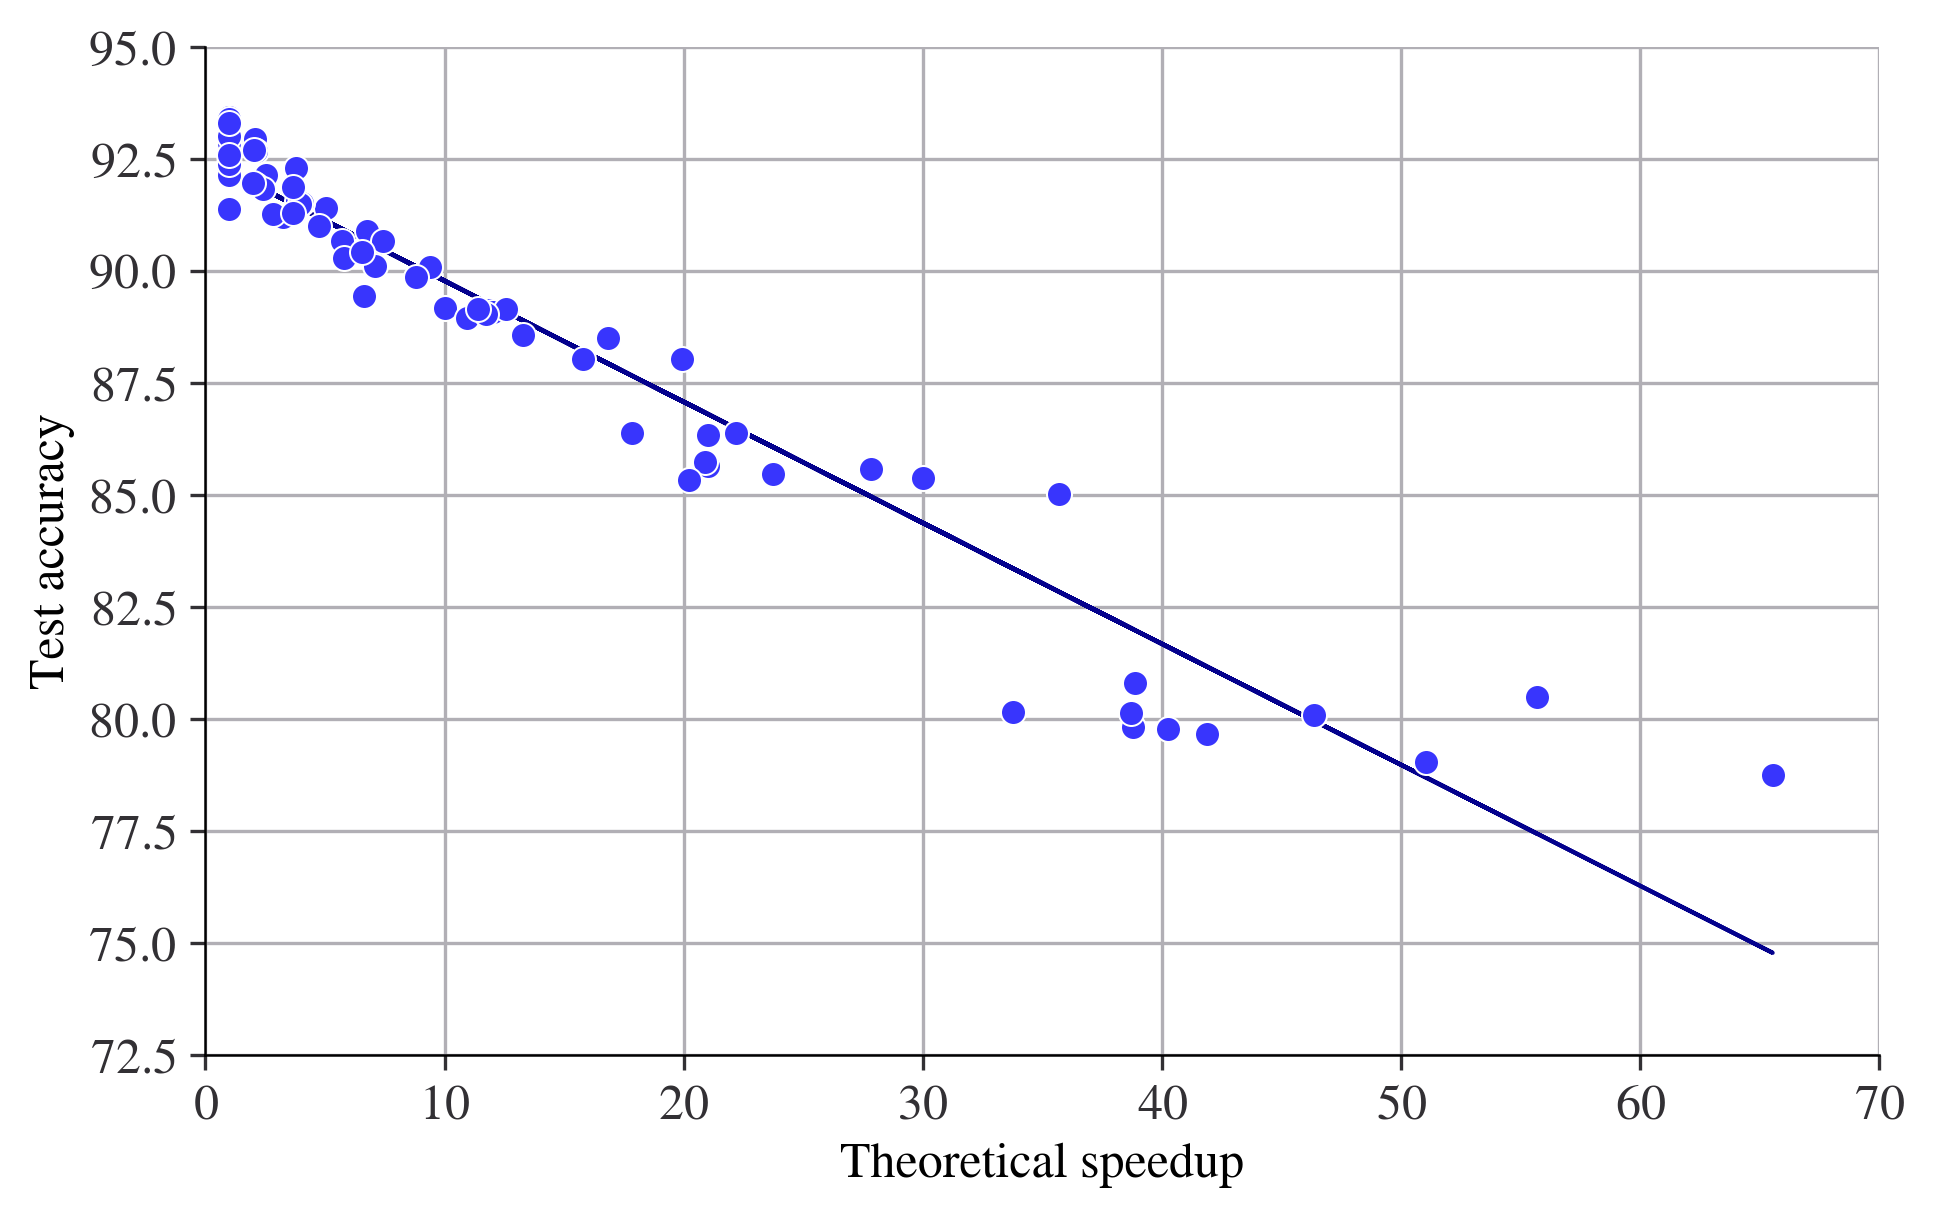

In [23]:
plt.grid()

data = data_final
ax = sns.scatterplot(data=data, x='speedup', y='best_accuracy', marker="o", color=BLUE, zorder=1000)

x, y = data.speedup.tolist(), data.best_accuracy.tolist()
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, y, ',', x, poly1d_fn(x), linewidth=1, color=DARKBLUE)

ax.set_ylabel('Test accuracy')
ax.set_xlabel('Theoretical speedup')
ax.set_xlim(0, 70)
#ax.set_yticks(range(85, 96))
#ax.set_ylim(85, 95)

savefig('speedup-accuracy.pdf')

# Comparison with others

In [24]:
# https://faculty.ucmerced.edu/mcarreira-perpinan/papers/cvpr18.pdf
# verified
carreira_perpinan = pd.DataFrame({
    'seed': [0, 0, 0, 0, 0],
    'compression_ratio': percent_to_cr([
        100, 15, 10, 5, 3
    ]),
    'best_accuracy': error_to_acc([
        6.86, 6.92, 6.67, 7.51, 8.21
    ]),
})

add_accuracy_changes(carreira_perpinan)

# verified
zhuang_2018 = pd.DataFrame({
    'name': ["Zhuang 2018" for _ in range(2)],
    'compression_ratio': [
        1.97, 3.37
    ],
    'accuracy_change': [
        -0.31, 0.01
    ]
})

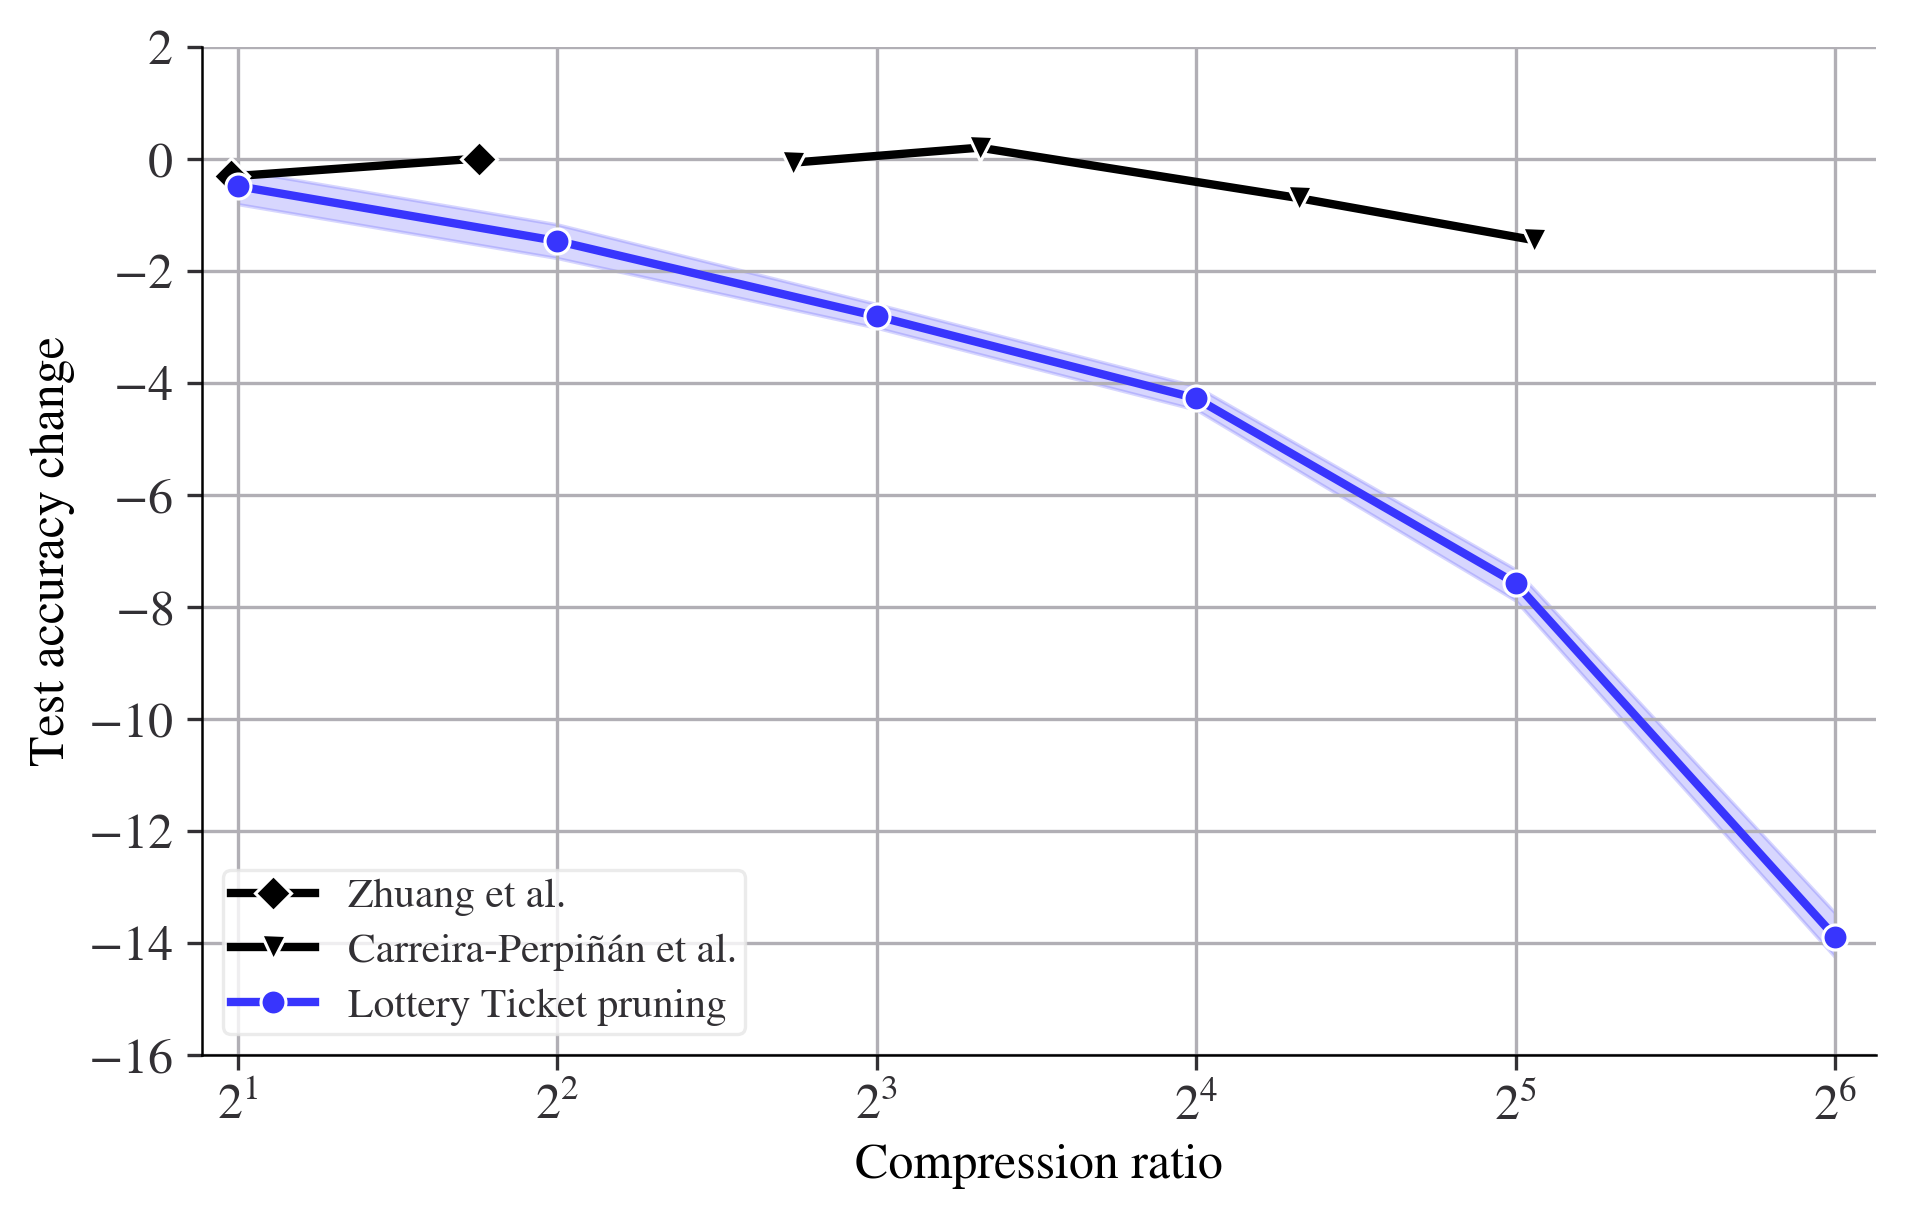

In [26]:
plt.grid()

ax = sns.lineplot(data=remove_initial(zhuang_2018), x='compression_ratio', y='accuracy_change', marker="D")
ax = sns.lineplot(data=remove_initial(carreira_perpinan), x='compression_ratio', y='accuracy_change', marker="v")
ax = sns.lineplot(data=remove_initial(data_final), x='compression_ratio', y='accuracy_change', marker="o", color=BLUE)

ax.set_xscale('log', base=2)
ax.set_xticks(ALL_RATIOS)
ax.set_xlim(1.85, 70)
ax.set_xlabel('Compression ratio')
ax.set_ylabel('Test accuracy change')

plt.legend(labels=['Zhuang et al.', 'Carreira-Perpiñán et al.', 'Lottery Ticket pruning'])

savefig('compression-accuracy-papers.pdf')

In [27]:
# verified
ding2018 = pd.DataFrame({
    'name': ["Ding 2018" for _ in range(4)],
    'seed': [0, 0, 0, 0],
    'compression_ratio': [
        1, None, None, None
    ],
    'multiply_adds': [
        1.42 * (10 ** 8), 5.55 * (10 ** 7), 5.72 * (10 ** 7), 4.14 * (10 ** 7), 
    ],
    'best_accuracy': error_to_acc([
        6.07, 7.06, 7.41, 9.43
    ])
})

add_accuracy_changes(ding2018)
add_speedups(ding2018)

# verified
he_yang2018 = pd.DataFrame({
    'name': ["He, Yang 2018" for _ in range(5)],
    'seed': [0, 0, 0, 0, 0],
    'compression_ratio': [
        1, None, None, None, None
    ],
    'multiply_adds': [
        125439624, 1.07*(10**8), 8.98*(10**7), 7.40*(10**7), 5.94*(10**7),
    ],
    'best_accuracy': [
        0.9359, 0.9389, 0.9347, 0.9310, 0.9226
    ]
})

add_accuracy_changes(he_yang2018)
add_speedups(he_yang2018)

# verified
he_yang2018_finetune = pd.DataFrame({
    'name': ["He, Yang 2018 (finetuned)" for _ in range(3)],
    'seed': [0, 0, 0],
    'compression_ratio': [
        1, None, None
    ],
    'multiply_adds': [
        125439624, 7.40*(10**7), 5.94*(10**7)
    ],
    'best_accuracy': [
        0.9359, 0.9378, 0.9335
    ]
})

add_accuracy_changes(he_yang2018_finetune)
add_speedups(he_yang2018_finetune)

# verified
zhuang_2018 = pd.DataFrame({
    'name': ["Zhuang 2018" for _ in range(2)],
    'speedup': [
        1.89, 1.99
    ],
    'accuracy_change': [
        0.01, -0.31
    ]
})

kim_2019 = pd.DataFrame({
    'name': ["Kim 2019" for _ in range(2)],
    'speedup': [
        1.4, 1.95
    ],
    'accuracy_change': [
        0.05, -0.2
    ]
})

peng_2019_ccp = pd.DataFrame({
    'name': ["Peng 2019 (CCP)" for _ in range(2)],
    'speedup': [
        1.9, 2.1
    ],
    'accuracy_change': [
        -0.01, -0.05
    ]
})

li_2017 = pd.DataFrame({
    'name': ["Li 2017" for _ in range(2)],
    'speedup': [
        1.1, 1.37
    ],
    'accuracy_change': [
        0.05, 0.01
    ]
})

In [28]:
speed_data = pd.concat([
    data_final,
    zhuang_2018,
    li_2017,
    peng_2019_ccp,
    ding2018,
    he_yang2018,
    he_yang2018_finetune,
    kim_2019,
], axis=0, ignore_index=True)

speed_data['Author'] = speed_data.name

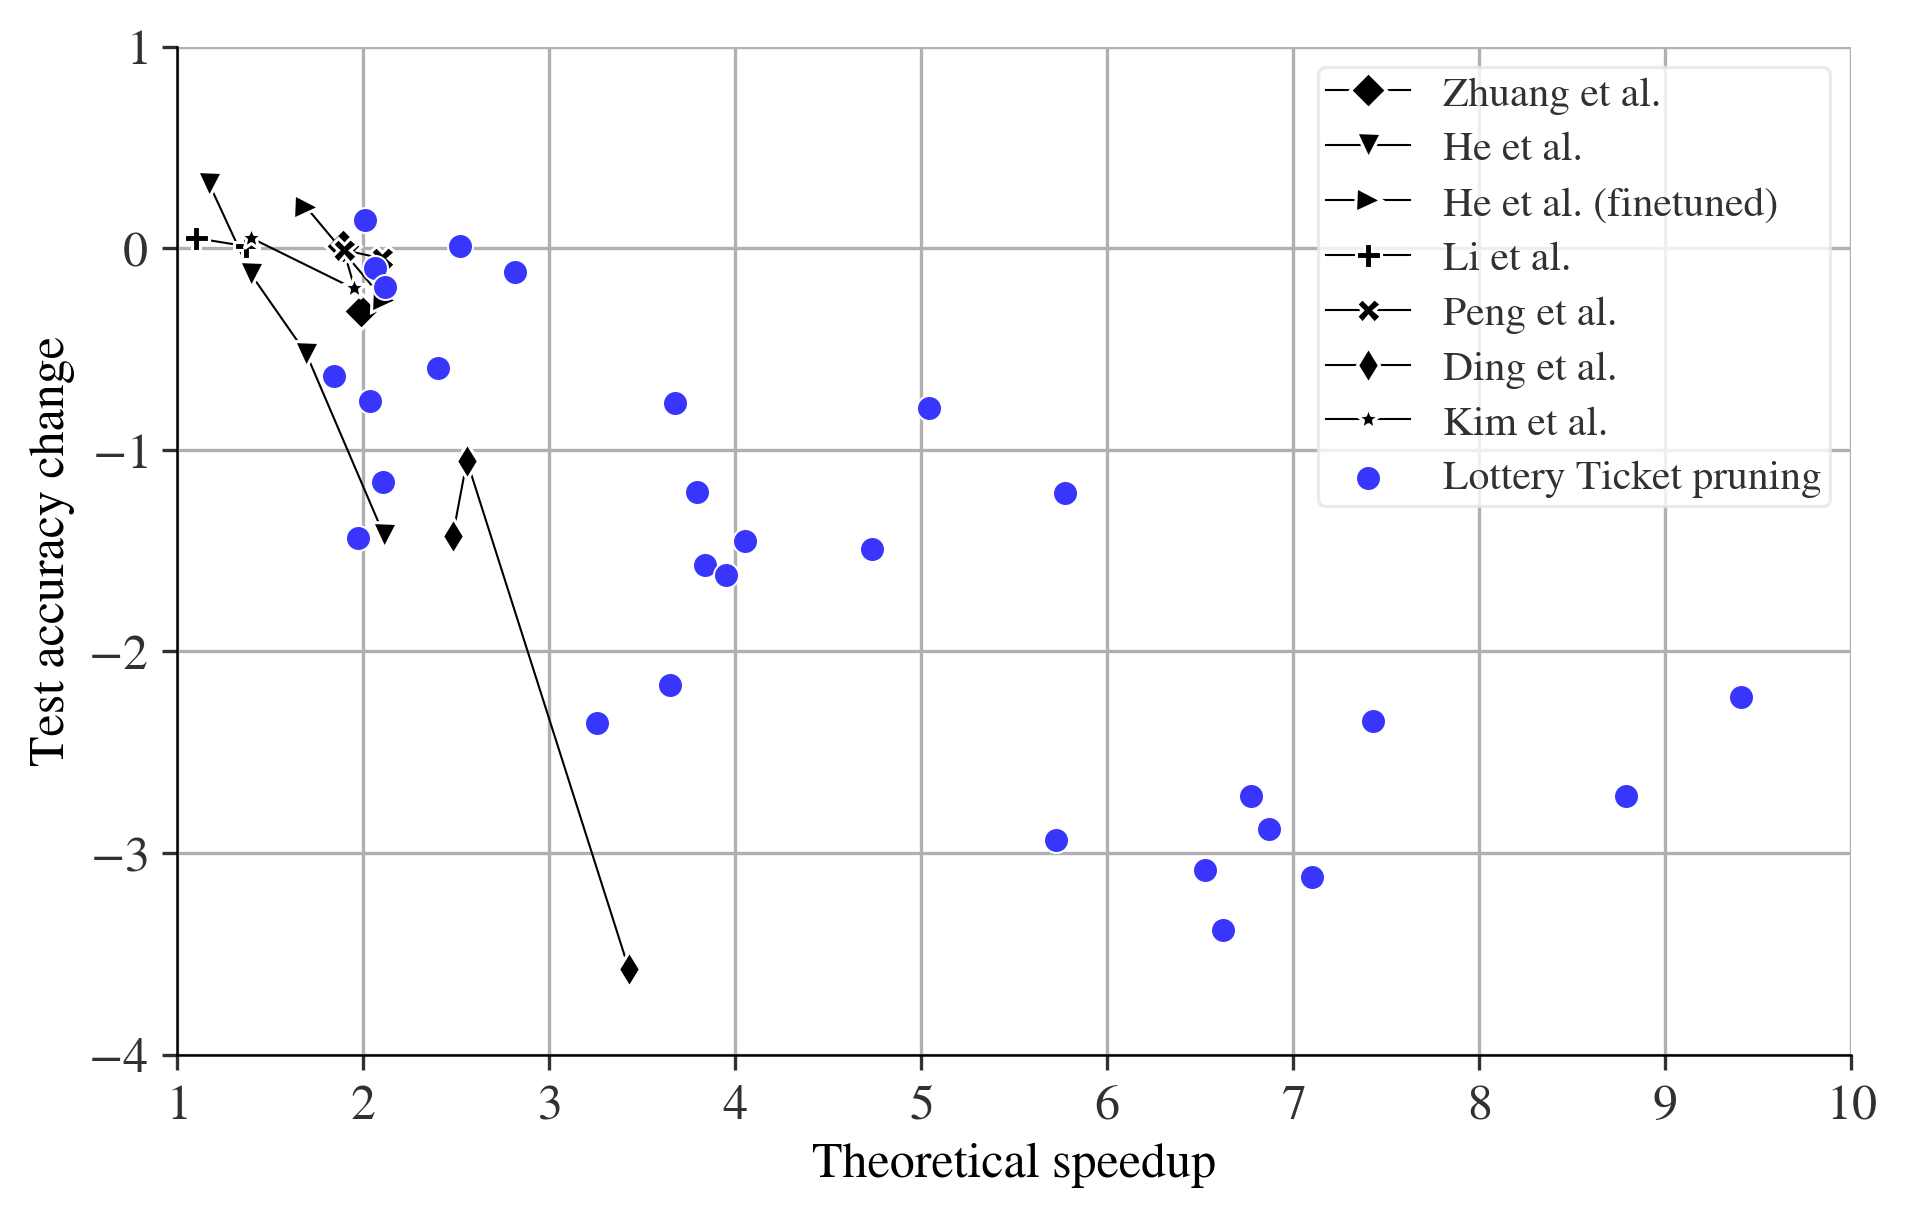

In [29]:
plt.grid()

ax = sns.lineplot(data=remove_initial(zhuang_2018), x='speedup', y='accuracy_change', marker="D", linewidth=0.5)
ax = sns.lineplot(data=remove_initial(he_yang2018), x='speedup', y='accuracy_change', marker="v", linewidth=0.5)
ax = sns.lineplot(data=remove_initial(he_yang2018_finetune), x='speedup', y='accuracy_change', marker=">", linewidth=0.5)
ax = sns.lineplot(data=remove_initial(li_2017), x='speedup', y='accuracy_change', marker="P", linewidth=0.5)
ax = sns.lineplot(data=remove_initial(peng_2019_ccp), x='speedup', y='accuracy_change', marker="X", linewidth=0.5)
ax = sns.lineplot(data=remove_initial(ding2018), x='speedup', y='accuracy_change', marker="d", linewidth=0.5)
ax = sns.lineplot(data=remove_initial(kim_2019), x='speedup', y='accuracy_change', marker="*", linewidth=0.5)
ax = sns.scatterplot(data=remove_initial(data_final), x='speedup', y='accuracy_change', marker="o", color=BLUE, zorder=1000)

ax.set_ylabel('Test accuracy change')
ax.set_xlabel('Theoretical speedup')
plt.legend(labels=['Zhuang et al.', 'He et al.', 'He et al. (finetuned)', 'Li et al.', 'Peng et al.', 'Ding et al.', 'Kim et al.', 'Lottery Ticket pruning'])

ax.set_ylim(-4, 1)
ax.set_xlim(1, 10)
ax.set_xticks(list(range(1, 11)))

savefig('speedup-accuracy-papers.pdf')

<img src="files/compare.png" width="500">

# Browser performance

In [30]:
def add_first_computation(data_df):
    first_comp = []

    for i in range(len(data_df)):
        this_row = data_df.iloc[i]

        base_row = data_df[(data_df.seed == this_row.seed) & (data_df.compression_ratio == this_row.compression_ratio) & (data_df.current_run == 1)]
        
        assert len(base_row) == 1
        comps = base_row.iloc[0].computation_times

        first_comp.append(comps[0])

    data_df['p_first_timing'] = first_comp

In [31]:
with open(BROWSER_PERFORMANCE_FILE, 'r') as f:
    browser_performance = pd.DataFrame(json.load(f)).drop(columns=['processed_images'])
    add_first_computation(browser_performance)
    
browser_performance3 = browser_performance[browser_performance.current_run == 3].copy()
add_speedups(browser_performance3, input_col='p_first_timing', output_col='p_first_speedup')
browser_performance3['p_marginal_timing'] = browser_performance3.total_time / 100
add_speedups(browser_performance3, input_col='p_marginal_timing', output_col='p_marginal_speedup')
browser_performance3 = browser_performance3.drop(columns=['computed_labels', 'computation_times', 'total_time'])
browser_performance3 = browser_performance3.rename(columns={'current_run': 'p_current_run', 'correct_images': 'p_correct_images'})

browser_performance3.head()

,seed,compression_ratio,p_current_run,p_correct_images,p_first_timing,p_first_speedup,p_marginal_timing,p_marginal_speedup
2,11696672,1,3,92,51.1932,1.000000,56.027900,1.000000
5,11696672,2,3,92,6.6334,7.717490,3.712551,15.091483
8,11696672,4,3,89,3.2618,15.694770,1.284412,43.621439
11,11696672,8,3,90,1.7115,29.911306,0.612947,91.407414
14,11696672,16,3,86,1.0079,50.791944,0.187307,299.123364


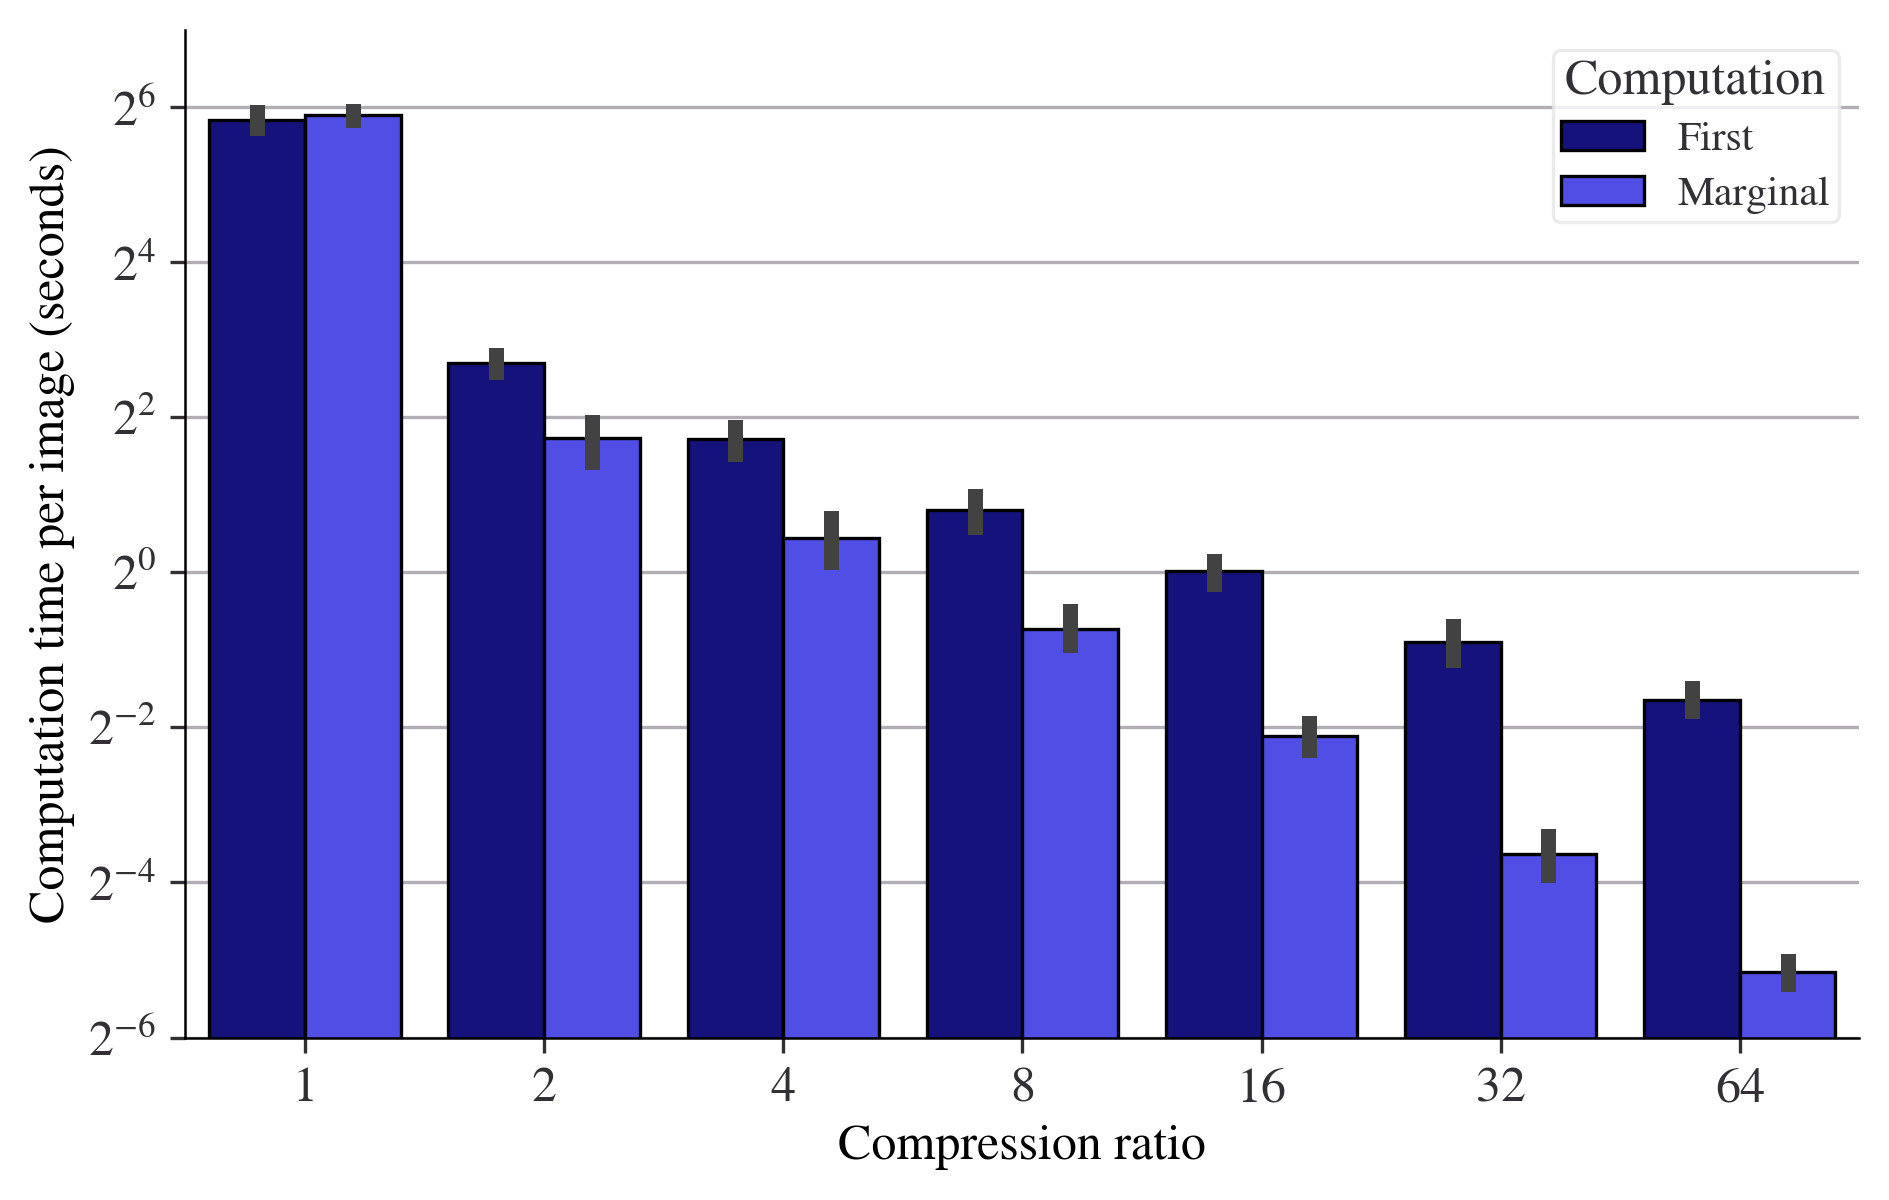

In [32]:
plt.grid()
data = (browser_performance3[['seed', 'compression_ratio', 'p_first_timing', 'p_marginal_timing']]
        .rename(columns={'p_first_timing': 'First', 'p_marginal_timing': 'Marginal'})
        .melt(id_vars=['seed', 'compression_ratio'])
        .rename(columns={'variable': 'Computation'})
       )
ax = sns.barplot(data=data, x='compression_ratio', y='value', hue='Computation', palette=[DARKBLUE, BLUE], zorder=2)

ax.set_yscale('log', base=2)
ax.set_xlabel('Compression ratio')
ax.set_ylabel('Computation time per image (seconds)');

savefig('compression-practical_time.pdf')

In [33]:
data_final_p = data_final.merge(browser_performance3, on=['seed', 'compression_ratio'], how='outer').dropna(subset=['p_current_run'])

data_final_p.head()

,compression_ratio,all_accuracies,seed,name,multiply_adds,best_accuracy,accuracy_change,speedup,p_current_run,p_correct_images,p_first_timing,p_first_speedup,p_marginal_timing,p_marginal_speedup
0,1.0,"[36.03, 43.85, 52.78, 62.25, 67.73, 69.24, 73....",11696672,Ours,126276224,93.420000,0.000000,1.000000,3.0,92.0,51.1932,1.000000,56.027900,1.000000
1,2.0,"[40.31, 55.03, 59.63, 60.11, 71.81, 72.01, 77....",11696672,Ours,61951007,92.710000,-0.760009,2.038324,3.0,92.0,6.6334,7.717490,3.712551,15.091483
2,4.0,"[45.26, 58.29, 68.64, 57.49, 76.77, 72.97, 76....",11696672,Ours,33251852,92.290000,-1.209591,3.797570,3.0,89.0,3.2618,15.694770,1.284412,43.621439
3,8.0,"[36.650001525878906, 53.220001220703125, 60.40...",11696672,Ours,18641858,90.879997,-2.718907,6.773800,3.0,90.0,1.7115,29.911306,0.612947,91.407414
4,16.0,"[39.689998626708984, 52.33000183105469, 58.849...",11696672,Ours,10623984,89.110001,-4.613572,11.885958,3.0,86.0,1.0079,50.791944,0.187307,299.123364


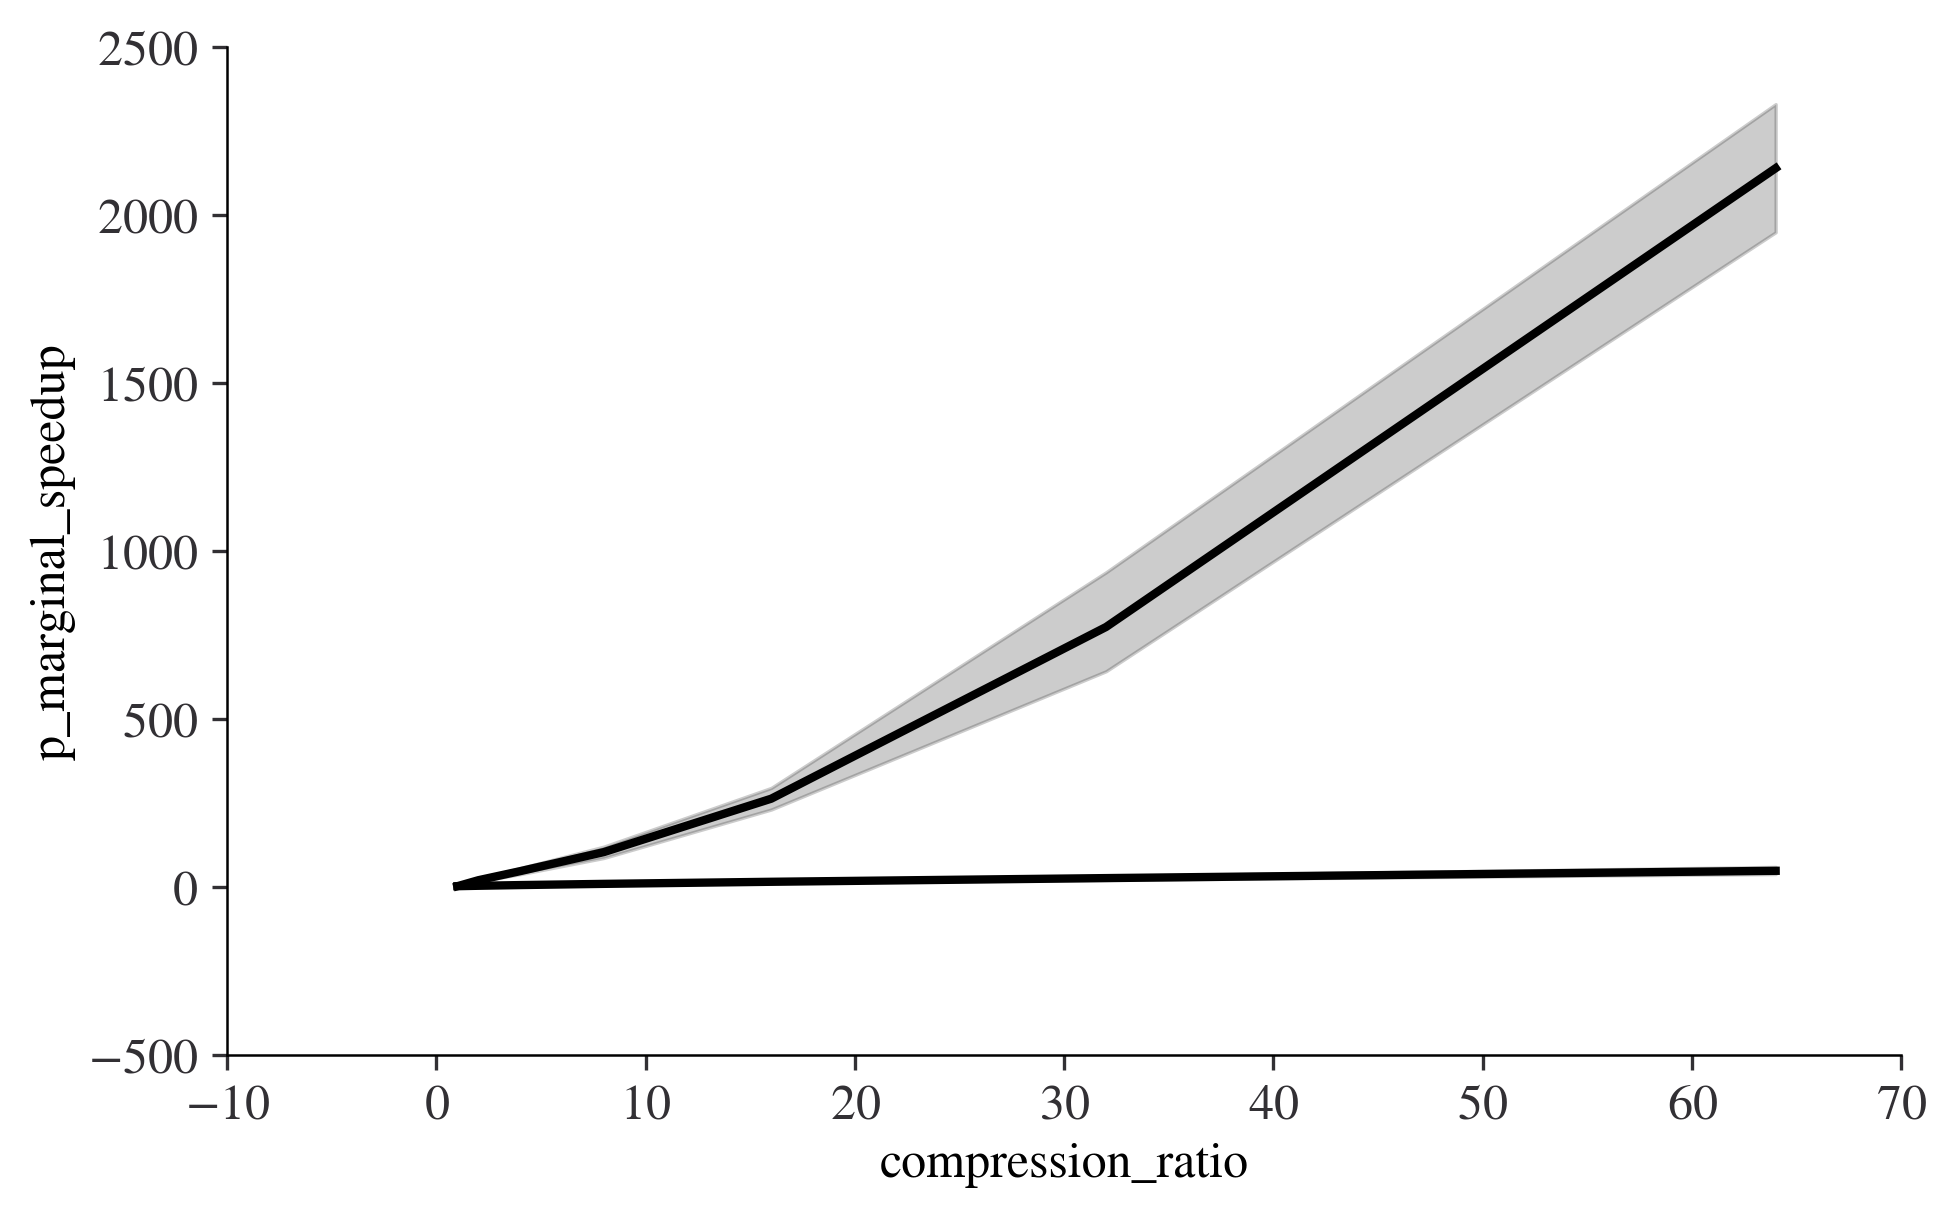

In [34]:
ax = sns.lineplot(data=data_final_p, x='compression_ratio', y='p_marginal_speedup')
ax = sns.lineplot(data=data_final_p, x='compression_ratio', y='speedup')

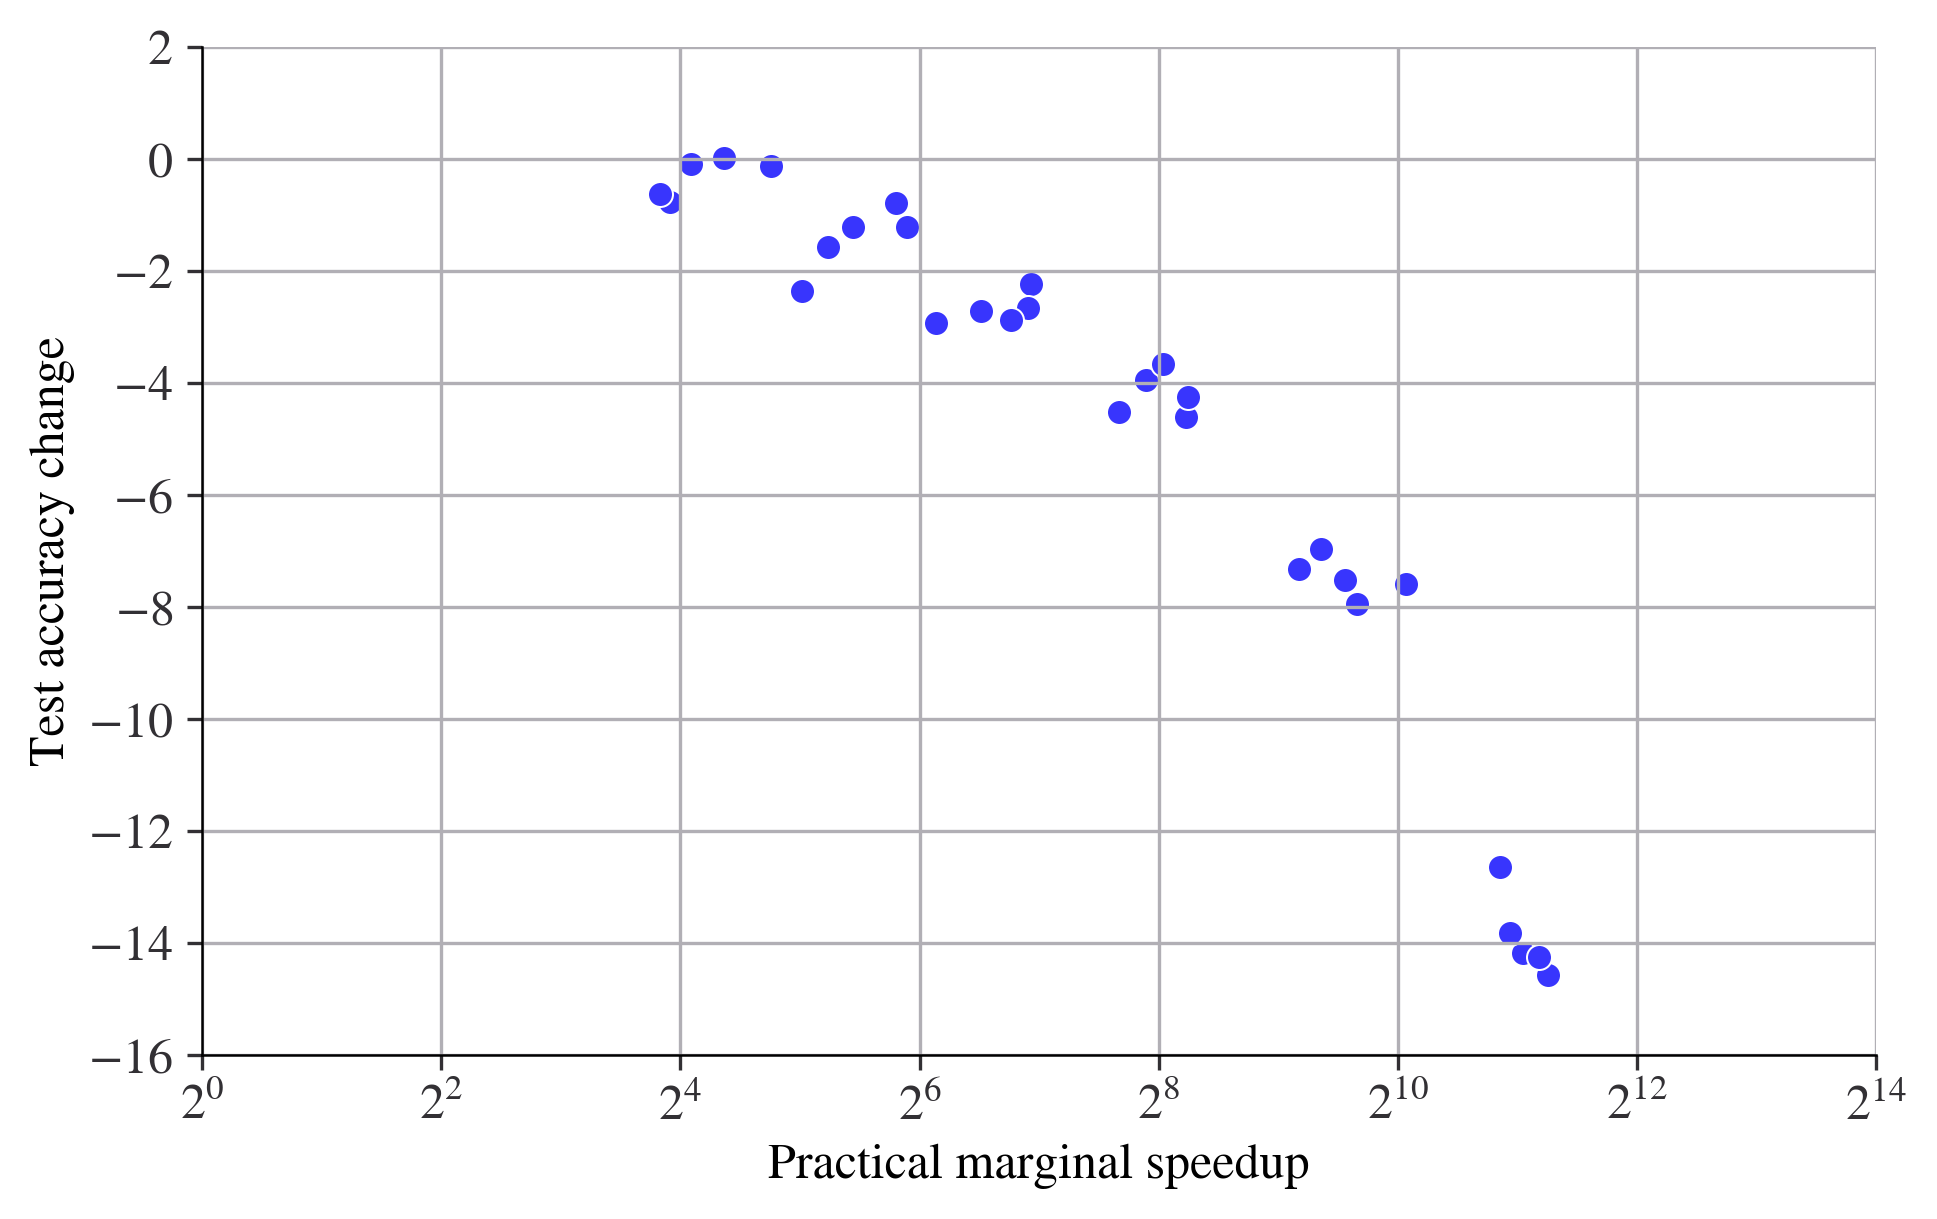

In [35]:
plt.grid()

ax = sns.scatterplot(data=remove_initial(data_final_p), x='p_marginal_speedup', y='accuracy_change', marker="o", color=BLUE)

ax.set_ylabel('Test accuracy change')
ax.set_xlabel('Practical marginal speedup')
ax.set_xscale('log', base=2)
ax.set_xlim(1, 2**14)

savefig('practical_speedup-accuracy.pdf')

In [36]:
for r in ALL_RATIOS:
    print("Compression ratio:", r)
    dd = data_final_p[data_final_p.compression_ratio == r].p_marginal_timing
    print("p_marginal_timing {:0.2f} +- {:0.2f}".format(dd.mean(), dd.std()))

Compression ratio: 1
p_marginal_timing 59.44 +- 2.78
Compression ratio: 2
p_marginal_timing 3.32 +- 0.71
Compression ratio: 4
p_marginal_timing 1.37 +- 0.33
Compression ratio: 8
p_marginal_timing 0.60 +- 0.13
Compression ratio: 16
p_marginal_timing 0.23 +- 0.04
Compression ratio: 32
p_marginal_timing 0.08 +- 0.02
Compression ratio: 64
p_marginal_timing 0.03 +- 0.00


In [37]:
for r in ALL_RATIOS:
    print("Compression ratio:", r)
    dd = data_final_p[data_final_p.compression_ratio == r].p_marginal_speedup
    print("p_marginal_speedup {:0.2f} \\pm {:0.2f}".format(dd.mean(), dd.std()))
    dd = data_final_p[data_final_p.compression_ratio == r].accuracy_change
    print("accuracy_change {:0.2f} \\pm {:0.2f}".format(dd.mean(), dd.std()))
    print()

Compression ratio: 1
p_marginal_speedup 1.00 \pm 0.00
accuracy_change 0.00 \pm 0.00

Compression ratio: 2
p_marginal_speedup 18.81 \pm 5.26
accuracy_change -0.32 \pm 0.35

Compression ratio: 4
p_marginal_speedup 45.76 \pm 11.68
accuracy_change -1.43 \pm 0.59

Compression ratio: 8
p_marginal_speedup 102.48 \pm 21.57
accuracy_change -2.68 \pm 0.28

Compression ratio: 16
p_marginal_speedup 261.47 \pm 42.12
accuracy_change -4.20 \pm 0.40

Compression ratio: 32
p_marginal_speedup 772.50 \pm 189.06
accuracy_change -7.47 \pm 0.36

Compression ratio: 64
p_marginal_speedup 2138.09 \pm 245.86
accuracy_change -13.89 \pm 0.75



In [38]:
data_final_p

,compression_ratio,all_accuracies,seed,name,multiply_adds,best_accuracy,accuracy_change,speedup,p_current_run,p_correct_images,p_first_timing,p_first_speedup,p_marginal_timing,p_marginal_speedup
0,1.0,"[36.03, 43.85, 52.78, 62.25, 67.73, 69.24, 73....",11696672,Ours,126276224,93.420000,0.000000,1.000000,3.0,92.0,51.1932,1.000000,56.027900,1.000000
1,2.0,"[40.31, 55.03, 59.63, 60.11, 71.81, 72.01, 77....",11696672,Ours,61951007,92.710000,-0.760009,2.038324,3.0,92.0,6.6334,7.717490,3.712551,15.091483
2,4.0,"[45.26, 58.29, 68.64, 57.49, 76.77, 72.97, 76....",11696672,Ours,33251852,92.290000,-1.209591,3.797570,3.0,89.0,3.2618,15.694770,1.284412,43.621439
3,8.0,"[36.650001525878906, 53.220001220703125, 60.40...",11696672,Ours,18641858,90.879997,-2.718907,6.773800,3.0,90.0,1.7115,29.911306,0.612947,91.407414
4,16.0,"[39.689998626708984, 52.33000183105469, 58.849...",11696672,Ours,10623984,89.110001,-4.613572,11.885958,3.0,86.0,1.0079,50.791944,0.187307,299.123364
5,32.0,"[45.11000061035156, 55.970001220703125, 53.380...",11696672,Ours,6004244,86.330002,-7.589379,21.031161,3.0,79.0,0.5364,95.438479,0.052291,1071.463541
6,64.0,"[40.380001068115234, 52.63999938964844, 54.939...",11696672,Ours,3254389,79.809998,-14.568617,38.801822,3.0,74.0,0.3141,162.983763,0.022942,2442.154128
7,1.0,"[40.459999084472656, 44.40999984741211, 56.229...",15713537,Ours,126276224,92.129997,0.000000,1.000000,3.0,87.0,56.7119,1.000000,59.899162,1.000000
8,2.0,"[40.91999816894531, 45.0, 54.939998626708984, ...",15713537,Ours,50049571,92.139999,0.010857,2.523023,3.0,92.0,6.2288,9.104787,2.900884,20.648589
9,4.0,"[42.290000915527344, 55.150001525878906, 62.79...",15713537,Ours,25035405,91.400002,-0.792354,5.043906,3.0,91.0,2.7150,20.888361,1.072565,55.846650
